### Genome-wide perturb-seq

This notebook prepares a dataset from a [paper with giant Perturb-seq experiments](https://www.cell.com/cell/fulltext/S0092-8674(22)00597-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867422005979%3Fshowall%3Dtrue) applied to all expressed genes or all essential genes.

Here we tidy the dataset and carry out a simple exploration in scanpy.

We start from a pseudo-bulk version where all cells are added together within each perturbation. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML
# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Specify the working directory explicitly.
os.chdir("/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/perturbations/")

### Load expression data & set up cell metadata

In [2]:
dataset_name = "replogle4"
expression_quantified = sc.read_h5ad(f"not_ready/{dataset_name}/rpe1_raw_bulk_01.h5ad")
expression_quantified.var_names = ingestion.convert_ens_to_symbol(
    expression_quantified.var_names, 
    gtf = "../accessory_data/gencode.v35.annotation.gtf.gz",
    strip_version=True,
)
expression_quantified

AnnData object with n_obs × n_vars = 2679 × 8749
    obs: 'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered', 'control_expr', 'fold_expr', 'pct_expr', 'core_control', 'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value', 'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI', 'mitopercent', 'TE_ratio', 'cnv_score_z'
    var: 'gene_name', 'mean', 'std', 'cv', 'in_matrix', 'gini', 'clean_mean', 'clean_std', 'clean_cv'

### Fill `perturbation` & `is_control` and find TF's

In [ ]:
human_tfs = pd.read_csv("../accessory_data/humanTFs.csv")
expression_quantified.obs["gene_symbol"] = [s.split("_")[1] for s in expression_quantified.obs.index]
expression_quantified.obs["is_tf"] = expression_quantified.obs["gene_symbol"].isin(human_tfs["HGNC symbol"])
expression_quantified.obs["ensembl_id"] = [s.split("_")[3] for s in expression_quantified.obs.index]
expression_quantified.obs["is_control"] = expression_quantified.obs["gene_symbol"].str.contains("non").astype("int")
expression_quantified.obs["perturbation"] = expression_quantified.obs["gene_symbol"]
controls = expression_quantified.obs.query("is_control==1")["perturbation"]

In [9]:
expression_quantified.obs["is_tf"].value_counts()

False    2272
True      407
Name: is_tf, dtype: int64

### Basic EDA

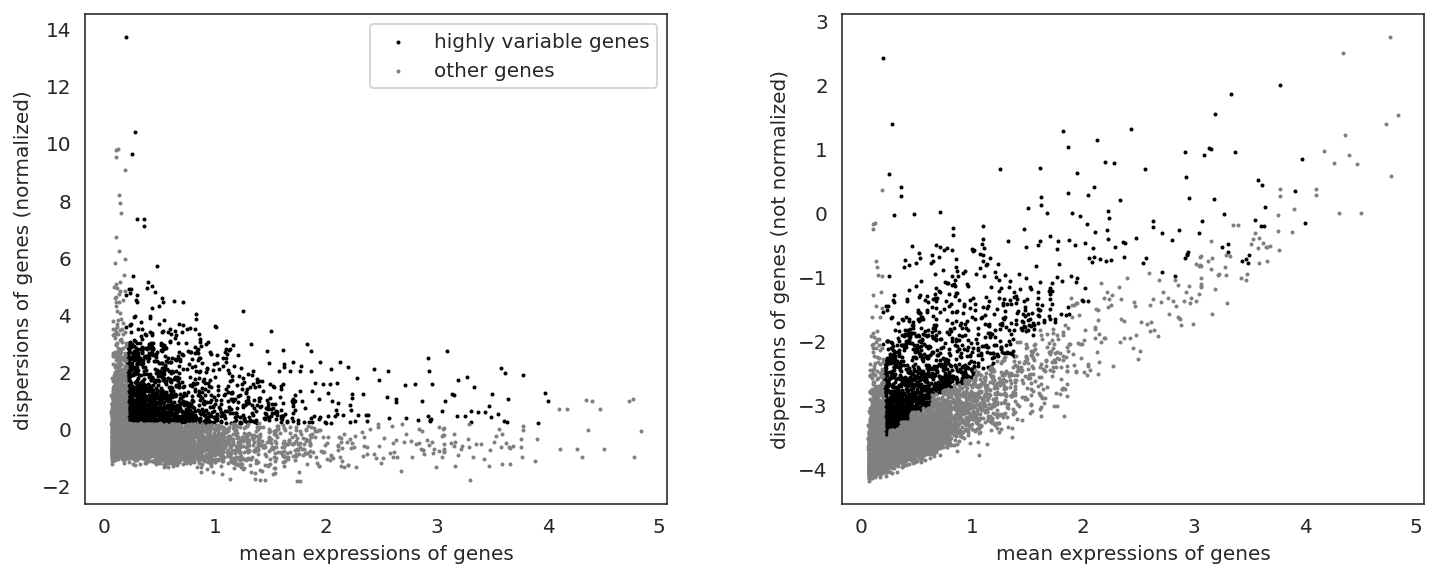

In [4]:
sc.pp.normalize_total(expression_quantified, target_sum=1e4)
sc.pp.log1p(expression_quantified)
sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=100)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []
sc.tl.leiden(expression_quantified)

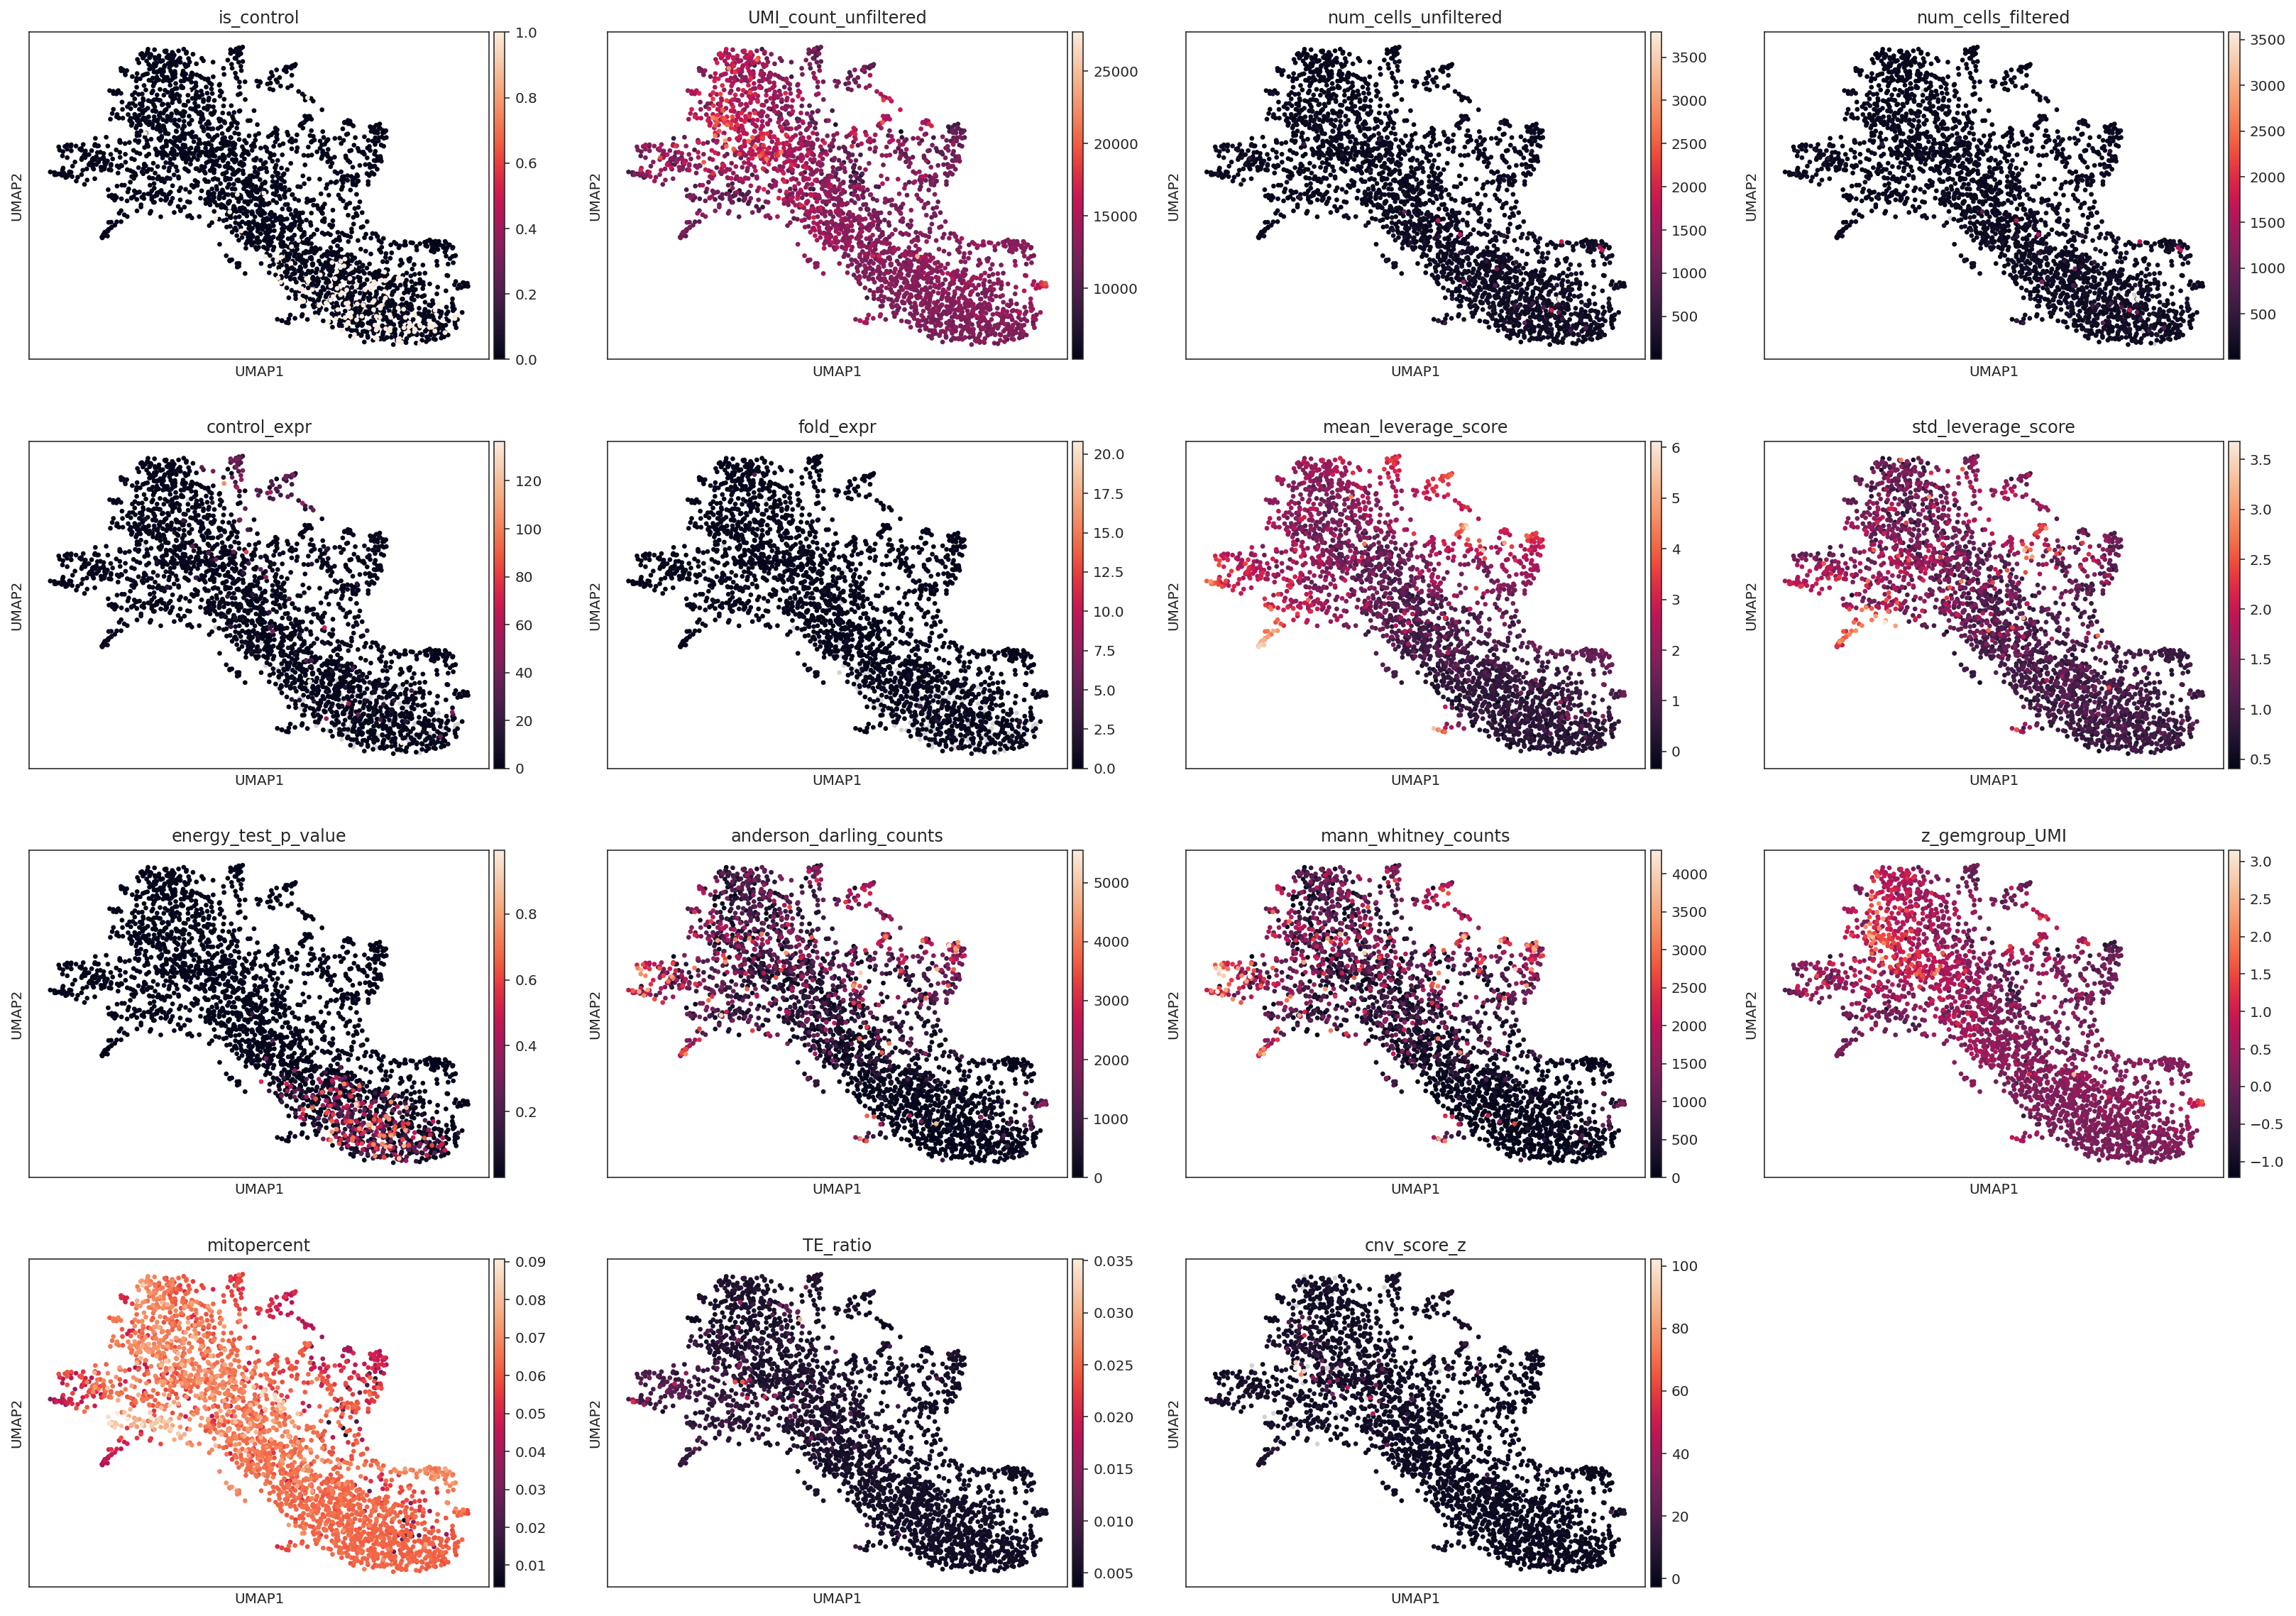

In [5]:
plt.rcParams['figure.figsize'] = [6, 4.5]
sc.pl.umap(expression_quantified, color = [
    "is_control",
    'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered',
       'control_expr', 'fold_expr', 
       'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value',
       'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI',
       'mitopercent', 'TE_ratio', 'cnv_score_z',
])
# Will ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
expression_quantified.obs["fake_cluster"]="all_one_cluster"
expression_quantified.obs.fake_cluster = expression_quantified.obs.fake_cluster.astype("category")
expression_quantified.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [6]:
perturbed_genes = set(list(expression_quantified.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(expression_quantified.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(expression_quantified.var.index)
genes_keep = expression_quantified.var.index[expression_quantified.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
expression_quantified_orig = expression_quantified.copy()
print("This many genes were perturbed:")
print(len(perturbed_genes))
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))

This many genes were perturbed:
2393
These genes were perturbed but not measured:
{'ZNF492', 'PPY', 'RBM14-RBM4', 'DNLZ', 'HAUS7', 'TULP1', 'ATRIP', 'OR4F4', 'SLC25A42', 'TARS', 'C12orf60', 'FOXL2', 'RNF123', 'HIST2H2AC', 'HOXC10', 'FAM102B', 'ZNF468', 'MTCP1', 'EPS8L1', 'GARS', 'SMN2', 'ZNF133', 'OR4N2', 'FRG2', 'MOCS3', 'LARS', 'POU5F1B', 'INTS9', 'TRIM49C', 'MYO1H', 'PARS2', 'HIST1H2BL', 'TBX1', 'NBPF15', 'HMX3', 'MED26', 'KLHL17', 'FOXO1', 'CYP4F11', 'ZNF317', 'CYS1', 'TBC1D28', 'ARID3A', 'MRM1', 'LTB4R2', 'DDN', 'SLC16A5', 'TMEM240', 'HIST1H2BM', 'HYPK', 'HAPLN2', 'ZNF335', 'XRCC3', 'DMRTA2', 'LRRC37B', 'RPTOR', 'LCE1E', 'CUL7', 'ACOT12', 'RARS', 'MED20', 'HARS', 'SPDYE2', 'AC118549.1', 'TRAIP', 'DEPDC5', 'CENPP', 'FNTB', 'HIST2H2BE', 'ZC3H3', 'TICRR', 'ADAT3', 'ZNF100', 'PRSS50', 'PTCD1', 'FOLR3', 'HINFP', 'ABCG1', 'KRTAP4-7', 'ACSS2', 'CCDC144A', 'H2AFX', 'MYB', 'TAF1A', 'MOG', 'SLC9B1', 'CSH2', 'PRODH', 'EARS2', 'ANKRD49', 'WDR24', 'ZBTB14', 'TAF6L', 'OLFML3', 'MARS2', 'LMO2', 

In [7]:
# final form, ready to save
expression_quantified = expression_quantified_orig[:,list(genes_keep)]
expression_quantified.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
expression_quantified.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)

In [8]:
os.makedirs(f"perturbations/{dataset_name}", exist_ok = True)
expression_quantified.write_h5ad(f"perturbations/{dataset_name}/test.h5ad")